<a href="https://www.kaggle.com/code/ksenia5/resnet50-for-object-detection?scriptVersionId=123540489" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Object detection in images with ResNet50

Use ResNet50, a 50-layer CNN model pretrained on > 40M images

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import random # for shuffling data

# Image tools from scikit image
from skimage import transform, color


import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# import image from keras preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50, decode_predictions

In [2]:
print(tf.__version__)

2.11.0


In [3]:
# define function to show image
def show_image(image, title='Image', cmap_type = 'gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

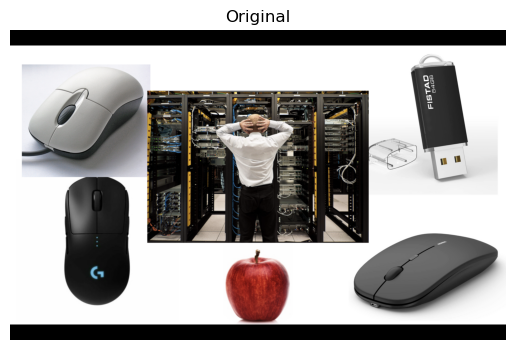

(1800, 2880, 3)
<class 'PIL.Image.Image'>
2880


In [4]:
# load test image
img_path = '/kaggle/input/objectDetection/img.png'
test_image = image.load_img(img_path)
test_shape = np.shape(test_image)
# display image
show_image(test_image, 'Original')
print(test_shape)
print(type(test_image))
print(max(test_shape))



## Image preprocessing

Resizing while maintaining aspect ratio

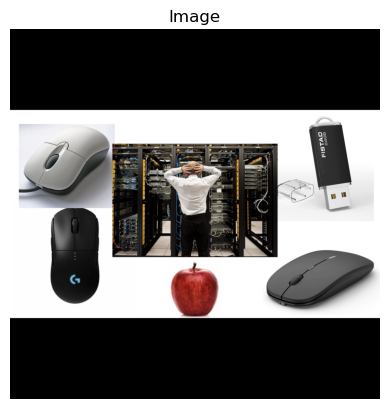

(2880, 2880, 3)


In [5]:
# resizing image to make square
square = tf.image.resize_with_crop_or_pad(test_image,target_height=max(test_shape),target_width=max(test_shape))
show_image(square)
print(square.shape)

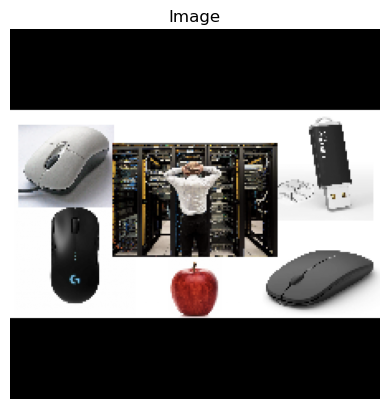

(224, 224, 3)


In [6]:
# scale down image to the right size
small_image = transform.resize(square,(224,224),anti_aliasing=False)
show_image(small_image)
print(small_image.shape)

The next test uses rescaled and padded image, and performs pretty badly with pretrained model

## Make predictions for objects in image
Using pretrained model out of the box


### Using resized and padded images 

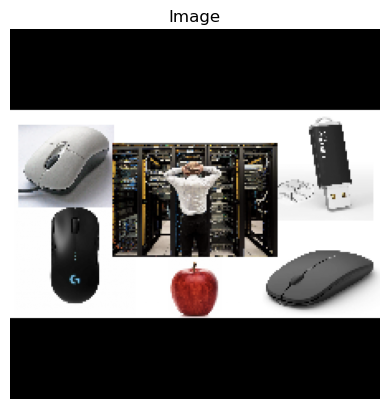

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03196217', 'digital_clock', 0.09412368), ('n03729826', 'matchstick', 0.076731555), ('n04286575', 'spotlight', 0.03503849), ('n01930112', 'nematode', 0.033637654), ('n06359193', 'web_site', 0.031819727)]


In [7]:
show_image(small_image)
# expand the dimensions so that it's understood by the network:
# img.shape turns from (224,224,3) into (1,224,224,3)
img = np.expand_dims(small_image, axis=0)

# pre-process the img in the same way training images were
img = preprocess_input(img)

# Instantiate a ResNet50 model with imagenet weights
model = ResNet50(weights ='imagenet')

# predict with ResNet50 on our img
preds = model.predict(img)


# Decode predictions and print it
print('Predicted:', decode_predictions(preds)[0])

The model does not identify any of the objects present in the image, and suggestions incorrect labels.

### Predictions using original image with minimal preprocessing
Next test loads and resizes image without scaling/padding.
<br>


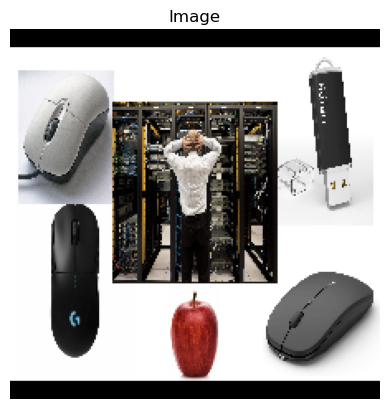

1/1 [==============================] - 1s 1s/step
Predicted: [('n04074963', 'remote_control', 0.2466726), ('n03793489', 'mouse', 0.17965712), ('n04023962', 'punching_bag', 0.1549728), ('n03777754', 'modem', 0.14508493), ('n04208210', 'shovel', 0.04338838)]


In [8]:
# # load the image with the right target size for the model
img = image.load_img(img_path, target_size=(224,224))
show_image(img)
# turn image into array
img = image.img_to_array(img)

# expand the dimensions so that it's understood by the network:
# img.shape turns from (224,224,3) into (1,224,224,3)
img = np.expand_dims(img, axis=0)

# pre-process the img in the same way training images were
img = preprocess_input(img)

# show_image(img[0,:,:,:])

# Instantiate a ResNet50 model with imagenet weights
model = ResNet50(weights ='imagenet')

# predict with ResNet50 on our img
preds = model.predict(img)

# Decode predictions and print it
print('Predicted:', decode_predictions(preds)[0])

The pretrained model does better with the second method (no rescaling or padding of image) even thoough the image is distorted (aspect ratio changes) when resized. Maybe because more of the original pixels are preserved?

## Transfer learning

Next, apply tranfer learning to improve pretrained model on our dataset.

<br>

### 1. Set model parameters 

In [9]:
# tensorflow keras models and layers for transfer learning 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Global Variables,number of images/classes to be identified 
NUM_CLASSES = 10
# Calculates average 
RESNET50_POOLING_AVERAGE = 'avg'
# Neural Network layer
DENSE_LAYER_ACTIVATION = 'softmax'

In [10]:
model_layers = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model_layers.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 10-class classification
model_layers.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model_layers.layers[0].trainable = False

model_layers.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Next load data and train model

## REFERENCES
1. [ResNet50 tutorial from DataCamp](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-keras/advanced-model-architectures?ex=6)
2. https://www.youtube.com/watch?v=j-3vuBynnOE
